In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.special import expit
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,make_scorer,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
ss=StandardScaler()

In [3]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
import random

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
le=LabelEncoder()

In [6]:
class TrainAuto:
    def __init__(self, dataset):
        
        #preprocessing step- setting up scaling for datasets which need them
        
        self.data=dataset
        self.scale=False
        
    def Traindata(self):
        column_titles=['Target']
        dft=pd.read_csv(self.data)
        
        #preprocessing step- changing the labels and deleting unwanted columns
        
        if ('Label' in dft.columns):
            dft['Label']=le.fit_transform(dft['Label'])
            dft.loc[dft['Label'] == 1, "Target"] = -1
            dft.loc[dft['Label'] == 0, "Target"] = 1
            dft.drop(['Label'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
        elif ('Class' in dft.columns):
            self.scale=False
            dft.loc[dft['Class'] == 1, "Target"] = -1
            dft.loc[dft['Class'] == 0, "Target"] = 1
            dft.drop(['Class','Time'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
        else:
            self.scale=True
            dft.dropna(axis=0,inplace=True)
            dft.reset_index(drop=True)
            let=LabelEncoder()
            dft['type']=let.fit_transform(dft['type'])
            dft.loc[dft['quality'].isin([3,4,5,6,7]),"Target"] = 1
            dft.loc[dft['quality'].isin([8,9]),"Target"] = -1
            dft.drop(['quality'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
            
        #using train-test split to create an appropriate split
        
        final_inliers = dft[dft['Target']==1]
        final_inliers_train, final_inliers_test = train_test_split(final_inliers, test_size=0.20, random_state=42)
        final_outlier = dft[dft['Target']==-1]
        len_outliers=final_outlier[:25]
        len_inliers=final_inliers_test[:18]
        
        #setting up validation set for hyper-parameter tuning
        
        if self.scale==False:
            final_val_set=pd.concat([len_outliers,len_inliers])
        else:
            final_val_set=pd.concat([len_outliers,len_inliers])
            final_val_set=pd.DataFrame(ss.fit_transform(final_val_set))
        if self.scale==False:
            final_train_scale=final_inliers_train.iloc[:,1:]
        else:
            final_train_scale=final_inliers_train.iloc[:,1:]
            final_train_scale=pd.DataFrame(ss.fit_transform(final_train_scale))
        final_test_scale=final_inliers_test.iloc[18:,1:]
        finoutlier_scale=final_outlier.iloc[25:,1:]
        yfin_test_in = final_inliers_test['Target'].iloc[18:]
        yfin_test_out = final_outlier['Target'].iloc[25:]
        y_fin_testval = pd.concat([yfin_test_in, yfin_test_out])
        y_fin_testval = np.array(y_fin_testval)
        if self.scale==False:
            df_fin_testval = pd.concat([final_test_scale,finoutlier_scale])
        else:
            df_fin_testval = pd.concat([final_test_scale,finoutlier_scale])
            df_fin_testval = pd.DataFrame(ss.fit_transform(df_fin_testval))  
        
        #returning the train, test and validation sets
        
        return final_train_scale,df_fin_testval,final_val_set,y_fin_testval
    
    def TuneData(self,val_set,train_set,df_test,y_test):
        f1list=[]
        #setting up parameters for OneClassSVM
        
        ocsvm_params = {'gamma' : ['scale','auto'], 'nu': [0.001,0.01,0.2,1], 'kernel':['poly','rbf','sigmoid','linear'],'degree':[3,5,8,10,12]}
        clf_ocsvm = GridSearchCV(OneClassSVM(), ocsvm_params, cv = 30, scoring='f1_micro')
        clf_ocsvm.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_fin=OneClassSVM(gamma=clf_ocsvm.best_params_['gamma'], nu=clf_ocsvm.best_params_['nu'],kernel=clf_ocsvm.best_params_['kernel'],degree=clf_ocsvm.best_params_['degree'])
        
        #Training model on the best parameters obtained
        model_fin.fit(train_set)

        #Testing the model and evaluating the f1-score
        pred_svm=model_fin.predict(df_test)
        f1list.append(f1_score(y_test,pred_svm))

        
        #Setting up parameters for Isolation Forest
        isofor_params={'contamination' : [0.0017304750013189597,0.19055313859,0.19590178], 'n_estimators': [300], 'max_features':[5,6]}
        clf_isofor = GridSearchCV(IsolationForest(), isofor_params, cv = 30, scoring='f1_micro')
        clf_isofor.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_iso=IsolationForest(contamination=clf_isofor.best_params_['contamination'], n_estimators=clf_isofor.best_params_['n_estimators'],max_features=clf_isofor.best_params_['max_features'])
        
        #training model on the best parameters obtained
        model_iso.fit(train_set)
        
        #Testing the model and evaluating the f1-score

        pred_iso=model_iso.predict(df_test)
        f1list.append(f1_score(y_test,pred_iso))

        #parameter dictionary for Elliptic Envelope
        
        ee_params={'contamination' : [0.2, 0.3, 0.19055313859,0.0017304750013189597], 'assume_centered': [True,False], 'support_fraction':[None,0.6,0.9]}
        clf_ee = GridSearchCV(EllipticEnvelope(), ee_params, cv = 30, scoring='f1_micro')
        clf_ee.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_ee=EllipticEnvelope(contamination=clf_ee.best_params_['contamination'], assume_centered=clf_ee.best_params_['assume_centered'],support_fraction=clf_ee.best_params_['support_fraction'])
        
        #training the elliptic envelope model on the best parameters
        
        model_ee.fit(train_set)

        #Testing the model and evaluating the f1-score

        pred_ee=model_ee.predict(df_test)
        f1list.append(f1_score(y_test,pred_ee))
        
        #parameter dictionary for Local Outlier Factor
        lof_params={'contamination' : ['auto',0.0017304750013189597,0.3], 'n_neighbors': [14,30]}  
        clf_lof = GridSearchCV(LocalOutlierFactor(), lof_params, cv = 30, scoring='f1_micro')
        clf_lof.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_lof=LocalOutlierFactor(contamination=clf_lof.best_params_['contamination'],n_neighbors=clf_lof.best_params_['n_neighbors'],novelty=True)
        
        #training the Local Outlier Factor model on the best parameters obtained
        model_lof.fit(train_set)

        #Testing the model and evaluating the f1-score

        pred_lof=model_lof.predict(df_test)
        f1list.append(f1_score(y_test,pred_lof))
        
        #returning the trained models in a list
        
        return f1list
    
    
   
        

# New section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<BarContainer object of 4 artists>

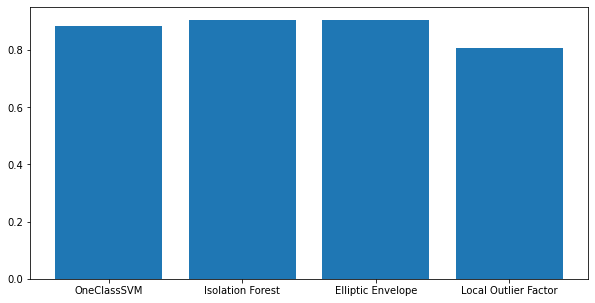

In [10]:
vd=TrainAuto('Vertebral.csv')
df_train,df_test,df_val,y_test=vd.Traindata()
verscore=vd.TuneData(df_val,df_train,df_test,y_test)
plt.figure(figsize=(10,5))
plt.bar(['OneClassSVM','Isolation Forest','Elliptic Envelope','Local Outlier Factor'],verscore)

<BarContainer object of 4 artists>

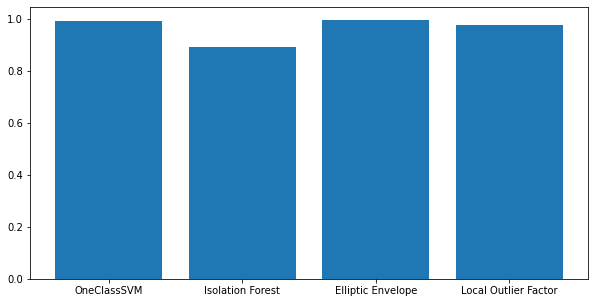

In [11]:
cc=TrainAuto('creditcard.csv')
df_train,df_test,df_val,y_test=cc.Traindata()
credscore=cc.TuneData(df_val,df_train,df_test,y_test)
plt.figure(figsize=(10,5))
plt.bar(['OneClassSVM','Isolation Forest','Elliptic Envelope','Local Outlier Factor'],credscore)

<BarContainer object of 4 artists>

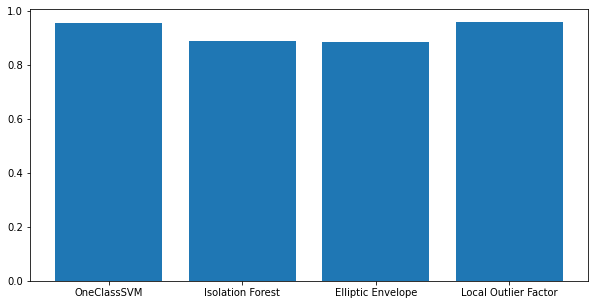

In [12]:
mg=TrainAuto('mammography.csv')
df_train,df_test,df_val,y_test=mg.Traindata()
mamscore=mg.TuneData(df_val,df_train,df_test,y_test)
plt.figure(figsize=(10,5))
plt.bar(['OneClassSVM','Isolation Forest','Elliptic Envelope','Local Outlier Factor'],mamscore)

<BarContainer object of 4 artists>

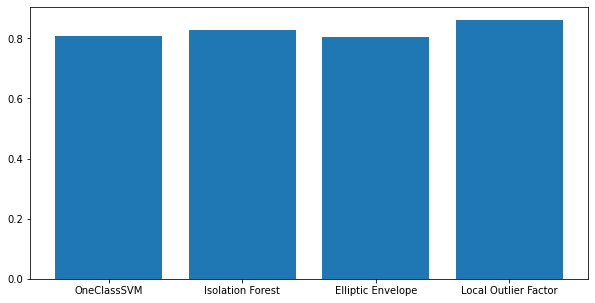

In [13]:
cg=TrainAuto('cardio.csv')
df_train,df_test,df_val,y_test=cg.Traindata()
carscore=cg.TuneData(df_val,df_train,df_test,y_test)
plt.figure(figsize=(10,5))
plt.bar(['OneClassSVM','Isolation Forest','Elliptic Envelope','Local Outlier Factor'],carscore)

<BarContainer object of 4 artists>

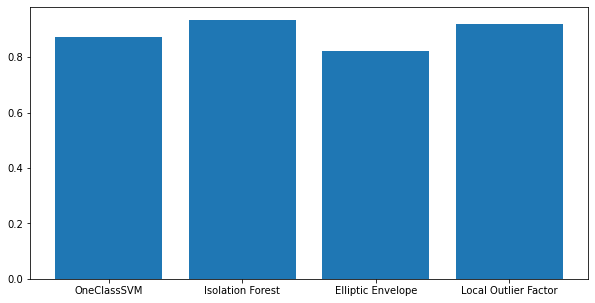

In [14]:
wq=TrainAuto('winequalityN.csv')
df_train,df_test,df_val,y_test=wq.Traindata()
winescore=wq.TuneData(df_val,df_train,df_test,y_test)
plt.figure(figsize=(10,5))
plt.bar(['OneClassSVM','Isolation Forest','Elliptic Envelope','Local Outlier Factor'],winescore)

In [26]:
df=pd.DataFrame([credscore,winescore,carscore,mamscore,verscore],index=['Credit Card','Wine Quality','Cardiotocography','Mammography','Vertebral Diseases'])

In [27]:
df.rename(columns = {0:'OneClassSVM', 1:'Isolation Forest',2:'Elliptic Envelope',3:'Local Outlier Factor'}, inplace = True)

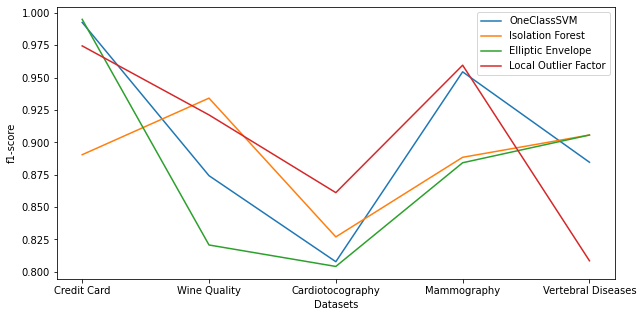

In [32]:
plt.figure(figsize=(10,5))
plt.plot(df.index,df)
plt.ylabel('f1-score')
plt.xlabel('Datasets')
plt.legend(df.columns)